In [60]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import mpld3
from mpld3 import plugins
from jinja2 import Template
# mpl.rcParams['figure.figsize'] = 3,3

# 1. Data Wrangling

In [62]:
data = []
for year in range(2010,2014):
    file = "movie_list_%s_v2.json" % year
    with open(file ) as data_file:    
        data += json.load(data_file)
    
df = pd.DataFrame(data)
df.describe()

,detail_url,douban_info,movie_tt_id,name,omdb_info
count,2064,2028,2064,2064,2064
unique,2041,2012,2041,2037,2038
top,http://www.movieinsider.com/m11397/desperate-a...,"{u'rating': {u'max': 10, u'average': 0, u'star...",tt1714866,Starbuck,"{u'Response': u'False', u'Error': u'Incorrect ..."
freq,2,2,2,2,4


In [63]:
# Problem, handling unicode json
df.drop_duplicates('movie_tt_id', inplace=True)
df['temp_string'] = df['douban_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df['temp_string'] = df['omdb_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df = df.dropna()
df.drop('temp_string', 1, inplace=True)
df.drop('detail_url', 1, inplace=True)
df.describe()

,douban_info,movie_tt_id,name,omdb_info
count,2003,2003,2003,2003
unique,2003,2003,1999,2003
top,"{u'rating': {u'max': 10, u'average': 7, u'star...",tt1860152,Frozen,{u'Plot': u'As inventor Andy Brewster is about...
freq,1,1,2,1


In [64]:
df['omdb_info'][0]

{u'Actors': u"Harriet Minto-Day, Jay Laga'aia, Damien Garvey, Sahaj Dumpleton",
 u'Awards': u'4 wins & 5 nominations.',
 u'Country': u'Australia, USA',
 u'Director': u'Michael Spierig, Peter Spierig',
 u'Genre': u'Action, Fantasy, Horror',
 u'Language': u'English',
 u'Metascore': u'57',
 u'Plot': u'In the year 2019, a plague has transformed almost every human into vampires. Faced with a dwindling blood supply, the fractured dominant race plots their survival; meanwhile, a researcher works with a covert band of vamps on a way to save humankind.',
 u'Poster': u'http://ia.media-imdb.com/images/M/MV5BNzg3NDYyMDU4Nl5BMl5BanBnXkFtZTcwODA5NzA5Mg@@._V1_SX300.jpg',
 u'Rated': u'R',
 u'Released': u'8 Jan 2010',
 u'Response': u'True',
 u'Runtime': u'98 min',
 u'Title': u'Daybreakers',
 u'Type': u'movie',
 u'Writer': u'Michael Spierig, Peter Spierig',
 u'Year': u'2009',
 u'imdbID': u'tt0433362',
 u'imdbRating': u'6.5',
 u'imdbVotes': u'98623'}

In [65]:
# Data problems
# 1.['imdb_info']['imdbRating'] do not exist
# 2.['imdb_rating'] is 'N/A', at id 108, 273
# 3.['imdb_rating'] is '23,421', need to get rid of the comma

df['imdb_rating'] = df['omdb_info'].apply(lambda x: x.get('imdbRating', np.nan))
df['metascore'] = df['omdb_info'].apply(lambda x: x.get('Metascore', np.nan))
df = df.dropna()
df = df[(df.imdb_rating != 'N/A') &(df.metascore != 'N/A')]
df['imdb_ratings_count'] = df['omdb_info'].apply(lambda x: int(x['imdbVotes'].replace(',', '')))
df['db_rating'] = df['douban_info'].apply(lambda x: x['rating']['average'])
df['db_ratings_count'] = df['douban_info'].apply(lambda x: x['ratings_count'])
df['image_url']=df['douban_info'].apply(lambda x: x['images']['medium'])
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['imdb_ratings_count'] = df['imdb_ratings_count'].astype(float)
df['name'] = df['name'].apply(lambda x: x.encode('ascii','ignore'))
df['metascore'] = df['metascore'].astype(float)
df['metascore'] = df['metascore']/10

df.drop('douban_info', 1, inplace=True)
df.drop('omdb_info', 1, inplace=True)

# 2. Movie Overview

In [66]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1662.000000,1662.000000,1.662000e+03,1662.000000,1662.000000
mean,6.386282,5.514019,5.268382e+04,5.901986,18715.155235
std,0.988046,1.703777,1.050602e+05,2.532974,46304.546623
min,1.600000,0.100000,1.200000e+01,0.000000,0.000000
25%,5.800000,4.300000,1.895500e+03,5.800000,131.500000
50%,6.500000,5.550000,9.648000e+03,6.600000,2010.500000
75%,7.100000,6.700000,5.588025e+04,7.500000,12730.750000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


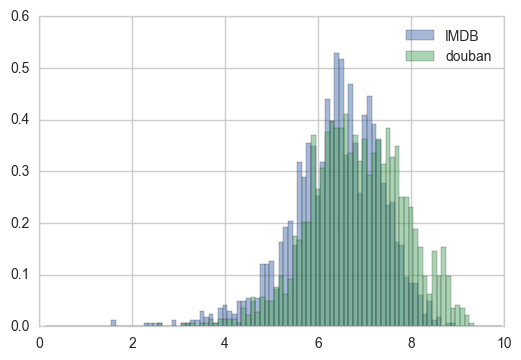

In [67]:
bins=arange(0.05,10,0.1)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins, alpha=0.5,  normed=True, label = 'douban')
plt.legend()

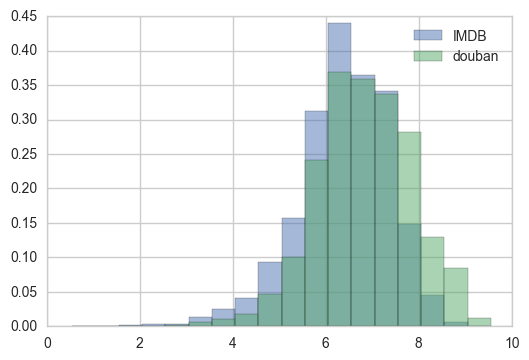

In [68]:
bins=arange(0.05,10,0.5)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins, alpha=0.5,  normed=True, label = 'douban')
plt.legend()

## 2.1 Empty Score Moives

In [69]:
empty_df = df.query('db_rating == 0')
display(empty_df.describe())
fig=plt.figure()
empty_df['imdb_rating'].hist(bins=arange(0.05,10,0.1), alpha=0.5)
plt_configure(title='No Douban rating, IMDB Rating Distribution',figsize=(3,2))
fig=plt.figure()
empty_df['imdb_ratings_count'].hist(bins=50)
plt_configure(title='No Douban rating, IMDB Rating Count Distribution', figsize=(3,2))
align_figures()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,227.000000,227.000000,227.000000,227.0,227.000000
mean,6.070925,5.250220,628.911894,0.0,7.048458
std,1.137316,1.645465,1053.300889,0.0,6.173906
min,2.300000,0.900000,12.000000,0.0,0.000000
25%,5.500000,4.150000,168.500000,0.0,2.000000
50%,6.200000,5.400000,391.000000,0.0,5.000000
75%,6.900000,6.500000,726.000000,0.0,12.000000
max,8.400000,8.600000,13492.000000,0.0,23.000000


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAASQAAADWCAYAAAB41P9KAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzt3Xl8XVW58PFfmoQmpW06UDpABRF4AF8GqYACMuoVLlem
Dy8I9cqsCFwQ9coLVpmEqwzyWi7DRS6Tghd8tYDCRVAKqIhAAb0IPhRooKVpY9M2aWmSJid5/1hr
pzsnZ9j7nJ2cndPn+/n0k549rL3OPmc/Z621h6emv78fY4xJgzGVroAxxgQsIBljUsMCkjEmNSwg
GWNSwwKSMSY1LCAZY1LDApIxJjUsIBljUsMCkjEmNepKXVFE+oD7VfULWdNPBS5X1Q+XUObBwEKg
H6gBMkAb8GvgX1W1tdT6Zm1nCXCZqt6bRHlJE5ETgKdVdZWIXAYcrKqHjcB2FwILVfXK0Gfxjqru
mGPZ/wJOBA5R1WdF5G7gi2z67LqBd4D/UNX5ofXuAk4NLdcJvAJ8VVVfylOvU4G7Quvgy38PuFFV
b4v4/sYDx6nqj/3rYfkeiMh2wJLQpD5gLfA73Pf4Lb/cwcBTqlobocxDgeWqqnnmhz+7u4B+VT2j
xPrvCYxT1T/GqWMSym0hnSwih+SYXs79KP3ADP9ve+B/A7sAT4lIYxnljgoi8iHgQWCcn3QdcHzl
asS2IrJbeIKI1AOfZfDn3A88wKbP7qPAjcB3ReQ7WWWGl9sL+BPwqIiMI7+loXVmAHsADwG3iMin
Ir6XrwGnh15/3NdlOPT78mcAHwKOBMYCz4jIdL/MH4CZEcv7LTC9wPzjgOtLq+oQC4Cd/P/j1LFs
JbeQvGbgZhHZU1V7E6gPAKr699DL90XkKECBc3Bf8mo2htCBrqobgA2Vqw7PAkcDr4emHe5ffyJr
2c7QZ9cKvONb0reIyO2quiLXciLyTeBs4DDgV3nqkcn6XrQCF4vIccCxuNZHMTXhF6raFmGdcqwK
teqX+7r+D3ApcKE/ZhJp9avq2iTK8Qb2U5J1jKLcgDQPuBX4V+Dfci0gItvggsjhuKbr/cA3VLUn
6kZ812UB7lfgRl/uJ4FrgY8BK4FrVfU//LwhTVZ/YByiqs/6SbuLyMvArsAzwNmqutQvewDwPWBv
XHB4BjhDVVf67sNpftp5uH14p6p+Pc/7X4j7Eh4F1OJaDnvlKx/XzekHlojI6cCHfb0PjbJtEbkI
+DowHrgH2B24u8RuST/wMPAFX9/AscAvGBqQcrkP+CHwj8CduRZQ1YyIdJdQP3Bdt4EfQxG5FDgL
2AZYhesyXun33WV+mYyq1oa7bP5zehI4yP9bCvyLqj7h15kC3AF8Bvd9uw64VVUj9zJUtVtE7gW+
BFzoexdPBWWIyAW4Vtx04DVcN/YPvp4AC0XkCuBdXABvBQ4FzvVlLlTVK/2yTf6YOQJ4ExcAn/bb
GdRVDbrnqjrG74ftgLt8/e4J5vll8x7PcY+NXMrtsr0PXA7M8/3mQXzTfiHQCHwK1/06ChdI4nod
2M2XuyuuCfs0LiBdAdwgIsfEKO8c3EE2B7fjgg9nIu5X+nFcsPoM8BHgktC6+wM7+7/n475chxfY
1mnAKbiAWluk/H39333Y1J0Id43ybltE5uIOuguAT+K6vAcV3ROFPQLsIyLT/DZqcC2mh8hqceSi
qt248ZTdcs0XkVoROQ8XWJ6KWikR2UJEzsXtw5/7aV/EvfczcF2OK4DLRWQv4L+AG4DncN2oXC7F
BdCPAq8Ct4fmPQBMxe3X83H7uZShideBbfx4Vn9Qhoh8DHdcnAMIrsX3oF9nH//3eDZ1y/bH/dDt
BzyRYzvHAX8G9sQF2gUiMqFAvYL3cjywDLjQ/xuYF/F4jntsDJLEWbb5wGL/N9uRuP7nXFV93Ufo
84Bzi4wX5NIOBDv0bOBlVf22qi72kf4m4JsxyrtZVR9U1deBM4GDRWRn3M6+UlWvVtX3VPWPuNbA
R0PrjsG1qBar6n24D36f7A2E/EpV/6Sqr0QoP+iWrPIHc7ZC2z4XN8j7C1V9Azd43BVjnwzhW41/
AT7nJ33S1+3tGMWEPzuAL4jIOhFZ5+s3H7jOd0/z2U5EOkLrbQC+Apyoqi/4Zd4FTlfVp/2+vR1Y
AXzU78v1wMasrl/Yo6r6Y1VdAnwXmC0iM/z34nDgi6r6mqo+jvshLkW7/5sdHLbDtTjeU9X3cL2P
L4jIGFVd5ZdZE9pHfcA1qvpmnq7ni6p6uaq+ievBtAEnF6ucqq7BnUzqUNV1WbOjHM9xj41Byg5I
qtqH+2IcJSJHZ83eBXhTVTtC054D6oEhZ26KmAgE5eyCGwgNew73axnVi8F/VPVdYDWwq+823Ssi
F4nIPSLyIvANXMsmsFJVPwi97sC9p3yaQ9uKUn4hhba9BzBwpsqPK+Q8KxPTw7hWEcAxuEHPOMKf
XVDeHrhf7z1x359/8y2cfN73y+4FfBlYg+sO/CJYQFWfAdpE5BoRWSAizbjuT9R9uzj0/6C+9bhu
b5v/ngT+GLHMbBP93+yD/de4Fs9rIrII9534mz++cmnN84MVCII0qtqPa/HFOT5yyXc817HpeI57
bAySyHVI/lf+Ltwv3ZahWbl+nWuz/ka1B65fXajcoMxBTWkRybWtTNbrMcBGEZmF+2Iciju4v4pr
6odtzFFeoe7LQH0jll9IoW335qhH0W5VBA8Dn/ZnOYPxo0hEZCyuCf8/ocnrVHWJqr7jf2lvx3WZ
zy9QVK9f521Vvd8ve4OIHBva1lnAb3Bns/4fbpD8/ah1Jf++TXK/7olrBa0PT1TVTlXdD/e9WIjr
5r8sIvnOcBVr+eb8fvv/Z3c1o44l5zvuath07MU9NgZJ8sLIi3HB6BuhaQrsLCKTQtP2B3qAyE1+
P6B4LJv61MrQAdX92dQa2MjgJvFHchS7e6j8nYAmv/5xuF/Do1X1JlX9g18/iQObCOWHr7WJ66+4
MTFgYDwsbkt0CFV9FdeVPA+oV9U/x1h9Lq578WiR5cJf6ih1egA3FneLH48B13K6QlW/7rsLq3Et
pPC+LcXrwOSscdKPxy1ERLbA7Y8Hc8z7hIhcqqrPqOo3cK2RBuDAEusc/n7X4k6gvOEnFTs+8u2n
RI7nQso9y3aXiJyuqs+q6moRuRh3JuJdEVkGfAt31ujHInIJMA3Xirovq9kXVhO6TqMeN8D3Pdz4
wH/66bcAF4jI1cDduJ3yFdwBA647doOIHIY7E/ED3KBp2NdE5DVfv38HHlHVd0SkDfiQX3cJ7uK/
4wk1gctUrPygubunr0scNwG3ichfcF++q3A/EsGg5JZAY2hMIo5fAt9m02eQS2PosxuPG3O4Grgq
a5wjvFwt7qCbC1xJPBfigsVlbBon+bSIPILrGl2N+46P9ct/AMwSke2yul/51ACo6mIR+TXu+34h
blD8igjrbu3PHtbixoiuwI0h5jqp0wlcJiIrca28Q3CfXRD8PwD+l4i8GqHeAAf5Y+4XuP1UjxvY
B3d8nCkiT+OOya9lrfsBsIuITM6a/iQFjmcRiVi1/EpqIflmeA3uLM4AVb0T16ecghv86mfT2MPz
uFOEC3BnEvLpB5b7f4uB23DXwhymqhv9dpYC/4Q7pfkX3NmRi0Kntn+MO/PyEPAY7sxJS9Y2bsAN
XD6HG/g80897EPgJ8DPcB3cI7gPb1Z9lyFfnQu8nrGD5/sD9iV/uTIoLX7P0AO509G24/b0EF8iD
ZvQ3CI2dxXwfD+OCzEMFlj+RTZ/dS7jLBc5X1e8VWG4JcA3us7iuwPaH8IPP1wH/Iu5ouBDX0n0V
12V7Ffd9+5hfZQEuOPzVnzUcOMuV471kTzsDNyj+PHAz7hKGXN2T8Lp/8u+xGfgp7sry/XMNQvtW
5+m4wPoG8H9

In [70]:
# these 2 table can be combined with an interactive table sorting
empty_df.sort_values(by='imdb_rating',ascending=False).head(30)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,image_url
1369,tt1606829,The Other Dream Team,8.4,6.9,2927.0,0.0,23,http://img3.douban.com/view/movie_poster_cover...
597,tt1283976,earthwork,8.4,5.3,811.0,0.0,0,http://img3.douban.com/mpic/s4628878.jpg
393,tt1699158,The Legend of Pale Male,8.3,5.1,24.0,0.0,0,http://img3.douban.com/mpic/s4512383.jpg
1473,tt2329758,Honor Flight,8.0,6.1,101.0,0.0,1,http://img3.douban.com/mpic/s23127957.jpg
1936,tt2119463,Let the Fire Burn,7.9,8.6,755.0,0.0,11,http://img3.douban.com/view/photo/thumb/public...
666,tt1511400,Just Like Us,7.8,4.9,69.0,0.0,0,http://img3.douban.com/f/shire/afee3c96d502c5a...
802,tt1708537,The Whale,7.8,6.4,444.0,0.0,20,http://img3.douban.com/mpic/s6828719.jpg
1725,tt1817235,Plimpton!,7.7,7.4,94.0,0.0,2,http://img6.douban.com/view/movie_poster_cover...
1928,tt2492916,Muscle Shoals,7.7,7.5,1862.0,0.0,18,http://img3.douban.com/view/movie_poster_cover...
70,tt1236244,Neil Young Trunk Show,7.6,8.3,84.0,0.0,4,http://img3.douban.com/mpic/s4212917.jpg


In [71]:
empty_df.sort_values(by='imdb_ratings_count',ascending=False).head(30)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,image_url
1318,tt1520498,The Oogieloves in the Big Balloon Adventure,7.2,3.2,13492.0,0.0,0,http://img3.douban.com/mpic/s9066428.jpg
208,tt1396557,Winnebago Man,7.2,7.1,3564.0,0.0,12,http://img3.douban.com/mpic/s4396761.jpg
1945,tt1662293,Nothing Left to Fear,4.4,1.2,3388.0,0.0,17,http://img3.douban.com/view/photo/thumb/public...
1442,tt2112293,The Comedy,6.4,4.6,3049.0,0.0,11,http://img3.douban.com/mpic/s7043567.jpg
1369,tt1606829,The Other Dream Team,8.4,6.9,2927.0,0.0,23,http://img3.douban.com/view/movie_poster_cover...
1950,tt2334896,The Dirties,6.7,6.0,2720.0,0.0,16,http://img3.douban.com/view/movie_poster_cover...
1790,tt2201221,Some Girls,4.6,4.8,2510.0,0.0,15,http://img3.douban.com/view/photo/thumb/public...
1089,tt1605782,Comic-Con Episode IV: A Fan's Hope,7.1,6.4,2356.0,0.0,15,http://img3.douban.com/mpic/s8873865.jpg
2046,tt2107648,Here Comes the Devil,5.7,5.0,2313.0,0.0,13,http://img3.douban.com/mpic/s12759318.jpg
930,tt1341340,A Warrior's Heart,5.5,2.4,1925.0,0.0,19,http://img3.douban.com/mpic/s6885054.jpg


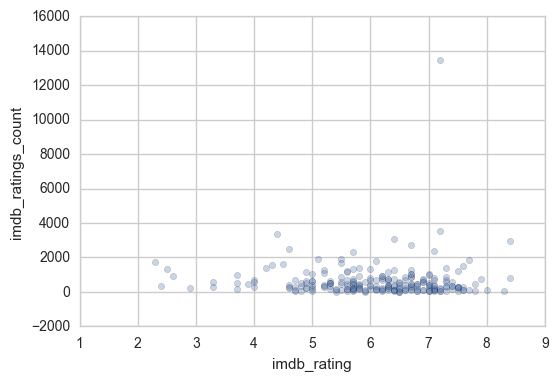

In [72]:
empty_df.plot(kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)

## 2.2 Delete Empty movies, Go ahead

In [73]:
df = df.query('db_rating > 0')

# 3. Movie Overview (with both ratings)

## 3.1 Overall Info

In [74]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1435.000000,1435.000000,1.435000e+03,1435.000000,1435.000000
mean,6.436167,5.555749,6.091829e+04,6.835610,21674.556098
std,0.953249,1.709649,1.108509e+05,1.022375,49186.918616
min,1.600000,0.100000,2.050000e+02,2.600000,20.000000
25%,5.900000,4.300000,3.924500e+03,6.200000,467.500000
50%,6.500000,5.600000,1.579300e+04,6.800000,3510.000000
75%,7.100000,6.800000,7.032400e+04,7.600000,16806.500000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


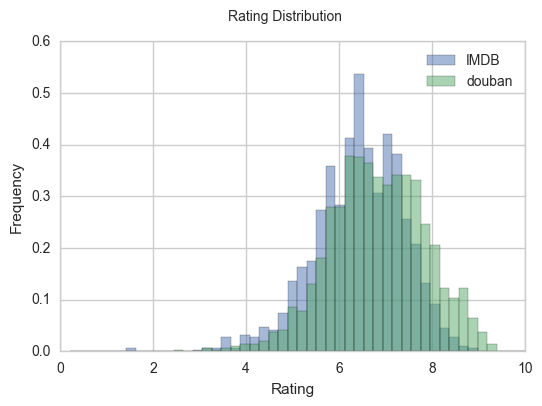

In [75]:
# 1. Why douban is higher?
# 2. Why the std is close to 1? (but IMDB < Douban, indicating a narrower distribution)
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

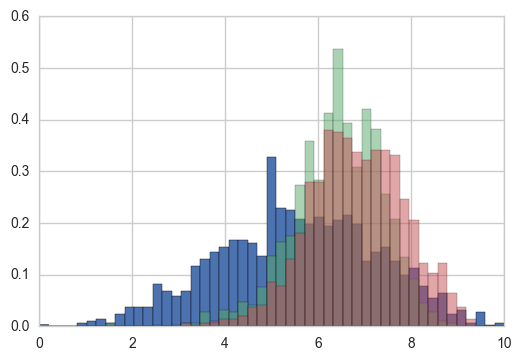

In [76]:
df['metascore'].hist(bins=bins, normed=True, label = 'Metascore')
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')

## 3.2 Good Movies

In [77]:
movie_records = df.to_dict(orient='records')
movie_records[0]

{'db_rating': 6.8,
 'db_ratings_count': 22650L,
 'image_url': u'http://img3.douban.com/view/movie_poster_cover/spst/public/p1174429818.jpg',
 'imdb_rating': 6.5,
 'imdb_ratings_count': 98623.0,
 'metascore': 5.7,
 u'movie_tt_id': u'tt0433362',
 u'name': 'Daybreakers'}

In [139]:
movie_template = Template('''
        <div class='thumbnail movie-thumbnail'>
            <div class='caption'>
                <h3 class='title'>{{movie['name']}}</h3>
                <img src={{movie['image_url']}}>
                <p><a class='btn btn-primary' >Douban {{movie['db_rating']}}</a> 
                <a class='btn btn-default'>IMDB {{movie['imdb_rating']}}</a></p>
            </div>
        </div>
''')

movie_list_template = Template('''
<div class='row'>
    {% for movie in movies %}
        <div class='col-xs-3'>
            {{movie_template.render(movie=movie)}}
        </div>
    {% endfor %}
</div>
''')

In [140]:
import sass
with open('./assets/application.css.scss', 'r') as myfile:
    sass_raw=myfile.read().replace('\n', '')
    css = sass.compile(string=sass_raw)
css = "<style media='screen' type='text/css'>" + css + '</style>'
HTML(css)

In [142]:
HTML(movie_list_template.render(movies=movie_records[:], movie_template=movie_template))

In [19]:
# Good Movies
df.sort_values(by='imdb_rating',ascending=False).head(20)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
1467,tt0110912,Tarantino XX: Pulp Fiction Event,8.9,9.4,1147612.0,8.7,240290
211,tt1375666,Inception,8.8,7.4,1255291.0,9.2,586362
1332,tt0082971,Raiders of the Lost Ark,8.6,9.0,574968.0,7.8,33528
1184,tt1675434,The Intouchables,8.6,5.7,406147.0,9.1,257411
754,tt1424432,Senna,8.6,7.9,40906.0,9.2,3722
1499,tt1853728,Django Unchained,8.5,8.1,789525.0,8.5,191003
1256,tt1345836,The Dark Knight Rises,8.5,7.8,975322.0,8.5,221766
1372,tt0056172,Lawrence of Arabia,8.4,10.0,167930.0,8.6,16770
181,tt0435761,Toy Story 3,8.4,9.2,457959.0,8.8,154035
479,tt1692928,The Last Lions,8.4,6.9,2871.0,9.2,4103


In [20]:
df.sort_values(by='db_rating',ascending=False).head(20)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
702,tt1613023,"Beats, Rhymes and Life: The Travels of a Tribe...",7.7,7.6,2482.0,9.3,66
754,tt1424432,Senna,8.6,7.9,40906.0,9.2,3722
479,tt1692928,The Last Lions,8.4,6.9,2871.0,9.2,4103
211,tt1375666,Inception,8.8,7.4,1255291.0,9.2,586362
819,tt1417592,Pearl Jam Twenty,8.3,5.9,6205.0,9.1,82
889,tt2011232,Inni,7.8,7.6,539.0,9.1,310
509,tt1621444,Bill Cunningham New York,7.9,7.6,3667.0,9.1,5197
1270,tt2125608,Searching for Sugar Man,8.2,7.9,43076.0,9.1,28242
1184,tt1675434,The Intouchables,8.6,5.7,406147.0,9.1,257411
1811,tt2106476,The Hunt,8.3,7.6,130749.0,9.0,61758


In [21]:
df.sort_values(by='metascore',ascending=False).head(20)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
1915,tt0032138,The Wizard of Oz,8.1,10.0,252429.0,8.1,20315
1372,tt0056172,Lawrence of Arabia,8.4,10.0,167930.0,8.6,16770
1968,tt2024544,12 Years a Slave,8.1,9.7,339383.0,7.7,70187
967,tt1832382,A Separation,8.4,9.5,131912.0,8.7,96551
317,tt1285016,The Social Network,7.8,9.5,420043.0,8.1,215689
1490,tt1790885,Zero Dark Thirty,7.4,9.5,196873.0,7.5,28385
1491,tt1602620,Amour (Love),7.8,9.4,63269.0,8.5,36611
1730,tt2209418,Before Midnight,8.0,9.4,78239.0,8.7,74102
344,tt1321865,Carlos,7.7,9.4,9265.0,7.3,721
1467,tt0110912,Tarantino XX: Pulp Fiction Event,8.9,9.4,1147612.0,8.7,240290


## 3.3 Ratings Number Distribution

In [22]:
# This plot is not very informative, what can I do?
# Why is this kind distribution? -> Poisson
fig=plt.figure()
df['imdb_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
fig=plt.figure()
df['db_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZsAAAFBCAYAAAChPQKxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzt3XlYVPXiP/A368wgaMguQaRZgLIL5oJeuaVpoNVE+wJ2
4xaLrfcbWpmppaVlBWqKWUa3mySXFDN8XG7XK+INAYUCr4KBoCyDCqEMDMv5/eGPk8MiMHKcGXu/
noeH5nzO8j6kvjlnzpxjIgiCACIiIgmZ6jsAERHd+Fg2REQkOZYNERFJjmVDRESSY9kQEZHkWDZE
RCQ5lg0REUmOZUNERJJj2RARkeRYNkT/X1JSEjw9PQEAP/30Ezw9PeHp6YlDhw71Ov+pU6fg6ekJ
Ly8vnD17FgCQkZEhLtf15evri7CwMCxevBi1tbVa6+htfj8/P8yZMwcbNmxAZ2entDtNdJ2Y6zsA
kaEwMTGBiYmJ1jQzMzNkZWVh8uTJPebftWtXn+tJTk6Gg4MDAKC5uRmlpaXYsGED9u7di61bt8LN
za3X+QVBQHNzM/Lz8/HJJ5+gtbUVCxYsGMK9JNIPHtkQXUVgYCD27NnT6xHGrl274O3t3etyXl5e
8PX1ha+vL+6880488cQT+Oabb9DR0YElS5b0Ob+fnx8mTZqEuLg4RERE4JtvvhnqXSLSC5YNUR9M
TEwwe/ZsNDQ04PDhw1pjx48fR0VFBe65554Br8/V1RUPP/wwDh06hMrKyn7nHz58eI8jLSJjxbIh
uoqxY8fitttuQ1ZWltb0Xbt2ISQkRDxVNlBTpkyBIAjIy8vTmt7R0SF+Xbp0CQcOHMD27dvxxBNP
XPM+EBkCvmdD1I/Zs2cjNTUVS5Ysganp5d/Pdu3aheeee27Q67K3twcA1NfXi9MEQcDdd9/dY15f
X188+eSTOqYmMiw8siHqx5w5c3DhwgXxVNqxY8dQV1eHWbNm6bzOK0+PmZiYYMOGDUhPT0d6ejq+
/vprvP3226itrcUjjzyCS5cuXfM+EOkbj2yI+tD1XEEPDw94eXmJV6Xt2rULU6ZMgY2NzaDXWVNT
AwBwdnbWmj527FiMGjVKfB0YGIixY8fisccew7fffouoqCjdd4TIAPDIhmgAZs+ejT179qC9vR27
d+9GRESETuvJzs6GqakpJkyY0O+848ePBwBUVFTotC0iQ8KyIerDlae6Zs+ejQsXLuDTTz9FY2Mj
wsLCBr2+mpoabNu2DTNmzICTk1O/8xcWFgK4fGRFZOx4Go2oD12n0QDAzc0NPj4++PTTTzFr1izI
5fKrLldcXAyVSgUAUKvVOH78OLZs2QIrKyu8+eabV52/s7MTpaWlSE5OhqOjI+6//34J9o7o+mLZ
EF2h+xv3V5ozZw5+/vln3Hvvvf2uIyEhQXxtYWGBUaNGYdasWXj22WdhZ2d31fnNzMwwcuRI3Hnn
nUhISMDw4cOvZZeIDIKJcOWvb0RERBLgezZERCQ5lg0REUmOZUNERJJj2RARkeQMomzOnz+PBQsW
IDg4GLNmzUJGRoY4VlVVhejoaAQEBCA8PBzZ2dlayx46dAgRERHw9/dHVFTUgO6mS0RE15dBlE1s
bCzq6uqQmpqKRYsWYeXKldi7d6845ujoiPT0dMydOxfx8fHiLT+qq6sRFxcHpVKJ9PR02NraIi4u
Tp+7QkREvdD7pc8///wzIiMjsXfvXri6ugIAUlJSsG/fPrz44ouIjY1FTk4OZDIZACA6OhpBQUGI
j4/Hxx9/jLy8PHz55ZcAgJaWFkyZMgWffvopgoOD9bZPRESkTe9HNpWVlRg5cqRYNABwxx134Oef
f8aRI0cwbtw4sWgAICgoCEePHgVw+XYeV5aKXC6Ht7c3CgoKrt8OEBFRv/ReNvb29vjtt9/Q2toq
TquurkZ7ezvOnTsHR0dHrfnt7OxQW1sLAKirq+sxbm9vL44TEZFh0HvZ+Pn5wcHBAUuXLoVarUZF
RQW++OILmJiYoLW1FZaWllrzW1paQqPRALh82uxq40REZBj0fm80S0tLfPLJJ3jxxRcRFBQEOzs7
/OUvf8GKFStgamoKtVqtNb9GoxFvgiiTyXoUi0ajGfC9pNrb29HY2AiZTCY+gZGIyJh1dnaitbUV
I0aMgLm53v+JFxlEkvHjx2Pv3r04d+4cbG1t8Z///AcjR46Eu7s7Dh48qDVvfX29+Nx3Jycn8U65
V457eXkNaLuNjY0oLy8fkn0gIjIkHh4ePW76qk96L5vGxkY8//zzWL9+vfiD+fHHHxESEgJfX19s
2LABGo1GPF2Wl5cnPnjKz88P+fn54rrUajWKi4u17qB7NV0XHtjb28Pa2nood0sSra2tqK6uhouL
i9ZFE4bK2PICxpeZeaVnbJkvXryI+vp6g8uq97IZMWIE1Go1Vq1ahb/+9a84fPgwMjIy8Pe//x1e
Xl4YNWoUEhMTERsbi/3796OoqAgrV64EACiVSmzevBkpKSmYMWMGkpOT4e7ujpCQkAFtu+vUmbW1
tUH9BtCX5uZmVFdX46abboKVlZW+4/TL2PICxpeZeaVnjJnr6+sN7q0Bg0izZs0aVFRUYO7cufjy
yy/x8ccfY9y4cTA1NcW6deugUqmgVCqRmZmJtWvXis9vd3V1RVJSEtLT0xEZGYmmpiYkJyfreW+I
iKg7vR/ZAJfPLaampvY65ubm1ucYAISGhiIrK0uqaERENAQM4siGiIhubCwbIiKSHMuGiIgkx7Ih
IiLJsWyIiEhyLBsiIpIcy4aIiCTHsiEiIsmxbIiISHIsGyIikhzLhoiIJMeyISIiybFsiIhIciwb
IiKSnN7LpqamBs899xyCgoLw5z//GVu2bBHHqqqqEB0djYCAAISHhyM7O1tr2UOHDiEiIgL+/v6I
iopCZWWljhlqUVFxWvyqr6+/pn0iIiJtei+bF154AcOGDUNGRgYWLVqEjz76CHv37gUAxMbGwtHR
Eenp6Zg7dy7i4+NRU1MDAKiurkZcXByUSiXS09Nha2uLuLg4nTLk/FKHndnl4teO3YeGbP+IiEjP
D0/77bffcOzYMbzzzjtwd3eHu7s7QkNDcfjwYVhbW6OqqgrffvstZDIZYmJikJOTg23btiE+Ph5p
aWnw8fFBVFQUAGDFihWYMmUKcnNzERwcPKgcNsNtYWXy+/O6O5vUQ7mbRER/eHo9spHL5VAoFEhP
T0d7eztOnTqF/Px8eHl54dixYxg3bhxkst9LICgoCEePHgUAFBYWapWKXC6Ht7c3CgoKrvt+EBHR
1em1bCwtLbF48WJ888038PPzw5w5czBt2jQolUqoVCo4OjpqzW9nZ4fa2loAQF1dXY9xe3t7cZyI
iAyHXk+jAUBZWRnCwsLwzDPP4MSJE1i2bBkmTZoEtVoNS0tLrXktLS2h0WgAAC0tLVcdJyIiw6HX
sul6D+bAgQOwtLSEt7c3ampqsH79ekyaNAkNDQ1a82s0GsjlcgCATCbrUSwajQbDhw8fdI729na0
X3GQ16HRoLm5WYc9kpZardb6buiMLS9gfJmZV3rGlrm1tVXfEXql17L55Zdf4OHhoXWE4uXlhQ0b
NsDJyQknT57Umr++vh4ODg4AACcnJ6hUqh7jXl5eg87RdLEJF9Wd4uu2CzUoKSkZ9Hqul/Lycn1H
GBRjywsYX2bmlZ4xZjYkei0bR0dHVFRUoL29Hebml6OcOnUKN998M/z8/LBhwwZoNBqxjPLy8jBh
wgQAgJ+fH/Lz88V1qdVqFBcXIyEhYdA5bKxtoLD+vfA6ZJd0Ki2pqdVqlJeXw8PDAwqFQt9x+mVs
eQHjy8y80jO2zA0NDaiurtZ3jB70WjZhYWFYtWoV3njjDTz33HM4deoUNmzYgFdeeQXBwcFwcXFB
YmIiYmNjsX/

## 3.4 Correlation between Rating and Rating Numbers

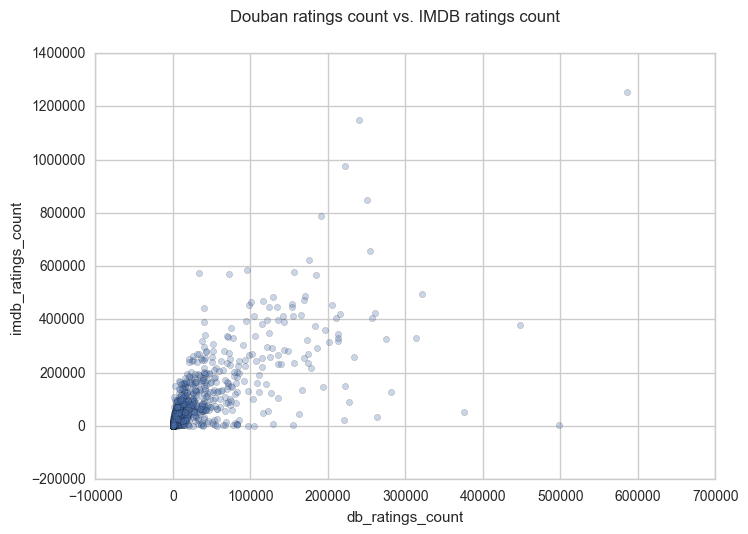

In [23]:
df.plot(kind='scatter', x='db_ratings_count', y='imdb_ratings_count', alpha=0.30)
plt_configure(title='Douban ratings count vs. IMDB ratings count')

In [24]:
fig, ax = plt.subplots()
df.plot(ax=ax, kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)
plt_configure(title='IMDB rating vs. ratings count', figsize=(4,3))
fig, ax = plt.subplots()
df.plot(ax=ax, kind='scatter', x='db_rating', y='db_ratings_count', alpha=0.30)
plt_configure(title='Douban rating vs. ratings count', figsize=(4,3))
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAacAAAFBCAYAAADT8mAHAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzs3Xtc1FX++PHXcJsB5SZyUzEvZKBcRTBNcE2/mq5GfUmz
rNRSS/HyLa31liPZSma3TdDMXdFwd9Mgay1XrdxfFy+JKGAhKRrKXVCGiwwzwMzvD5ZPjNxkGGPU
83w8euicM5/Pec8n5D3nfM7nHJler9cjCIIgCGbEoqsDEARBEIQbieQkCIIgmB2RnARBEASzI5KT
IAiCYHZEchIEQRDMjkhOgiAIgtkRyUkQBEEwOyI5CYIgCGZHJCdBEATB7IjkJNy0TZs24ePjI70+
ceIEPj4++Pj4cPTo0RaPuXjxIj4+Pvj6+lJQUADA3r17peMa/wsICODBBx9kzZo1FBcXG5yjpfcH
BgYyadIktm7dik6nu2Wf+fDhw/zpT39q9plTUlJuWZu3k+zsbKZPn25Q5uPjQ1xcXBdFZN5u/HkS
WmfV1QEItw+ZTIZMJmtWbmlpyYEDBxg5cmSzuv3797d6rri4OFxdXQGorq4mOzubrVu38vXXX7N7
9268vLxafL9er6e6uppTp07x/vvvo9FoWLx4sYk+paGEhASDzzxkyBD27NnDwIEDb0l7t5sDBw6Q
np5uULZnzx7c3d27KCLzduPPk9A60XMSOm3o0KF89dVXLfZg9u/fz+DBg1s8ztfXl4CAAAICArj/
/vt56qmn+Pjjj6mvr2ft2rWtvj8wMJARI0YQHR3NlClT+Pjjj039kVrVrVs3AgIC6Nat2+/Wpjlr
aWnOgIAAkZyEThPJSegUmUzGxIkTUalUHD9+3KAuKyuLS5cu8dBDD930+Xr37s3jjz/O0aNHyc3N
bff9Dg4O7X4Tffrpp3n55ZdZvHgxwcHBPPfccwDk5eXxyiuvEB4ejp+fHyNHjuRPf/oT5eXl0nEp
KSmcOHECX19f6e9Nh/Xi4uIYP3483377LQ8//DD+/v5MmDCBzz//3CCGixcvMnfuXEJCQhg1ahTv
vvsuK1eu5Omnn24x5uLiYgYPHszf//53g/KysjL8/PzYuXMnAEeOHOHxxx8nODiYsLAwFixYwMWL
F9u9bk01fob4+HiGDx9OeHg4lZWVaDQa3n77bSZMmIC/vz8hISE8++yzZGVlScfFx8ej1+vx9fWV
hvKaDus1Xq9jx47x3HPPERQUxKhRo3jrrbcMEtv169dZs2YNI0eOJDg4mJdeeokdO3YYDCPn5uYy
f/58hg8fTlBQENOnT+fbb79t9/Pt2LGDSZMmERgYyPjx49m+fbtB/ZEjR5gxYwbDhg1j+PDhLF26
lKKiIqn+xuHsRk0/Z35+Pj4+Phw4cIDFixczdOhQhg8fzquvvkpNTQ3Q8s+T0DqRnIROu/fee/H2
9ubAgQMG5fv37ycsLEwaurtZDzzwAHq9ntTUVIPy+vp66b/r16/z3Xff8fnnn/PUU0+1e85///vf
dO/enS1btjBnzhxqamp45pln+PXXX1m7di3bt29n5syZfPnll7z77rsArF27lsGDBzN48GB2794t
9QBvTIYlJSWsW7eOWbNm8eGHH9KnTx+WL1/Or7/+CjQklBkzZlBUVMSGDRtYtWoVBw8e5Isvvmg1
sbq7uxMWFtZsWPTf//43AFOmTCE3N5fo6Gj8/f3ZunUr69ev59dff+X555+/iatsqKCggO+++473
3nuPFStWYG9vz8svv8zevXt54YUXSEhIYMWKFZw/f55ly5YBMHXqVB577DFkMhm7d+9m6tSprZ7/
5ZdfZtiwYWzdupUpU6bw17/+lU8++USqnz9/PgcPHmTJkiW89957VFdX884770jXR6/XM2/ePGpq
anjrrbfYsmULTk5OREdHt/klZsOGDWzcuJFx48bxwQcf8Nhjj/HWW2/x4YcfAvDZZ5/x3HPP0atX
L9555x1WrlxJWloajz/+ONeuXQNaH85uiVKppE+fPmzevJnnnnuOpKQktmzZArT+8yS0TNxzEkxi
4sSJJCYmsnbtWiwsGr7z7N+/nxdeeKHD5+rZsycApaWlUpler+d//ud/mr03ICCg1d5HU9bW1sTE
xGBtbQ009Op69erFhg0b6N27NwBhYWGkpaVx4sQJAAYOHEi3bt2QyWQEBAQYxNJUTU0Nf/7znxk+
fDgA/fr1Y8yYMXz77bf079+fjz76CLVaTUJCgvTZAgMDmTBhQpsxR0ZGsmrVKoqKivDw8AAarunI
kSPp0aMHx48fR6PR8Pzzz0tfANzd3fnmm2+orq7Gzs6u3evSqL6+nuXLlxMcHAxAbW0tarWaV199
VYpz2LBhVFVVsWHDBq5evYq7u7sUV9Pr05LHH3+c+fPnAzB8+HC++uor/vOf/zBt2jSOHTvGiRMn
iIuLY9y4cQBEREQwefJkqRd49epVfv31VxYuXEh4eDgA/v7+xMfHo9VqW2yzsrKSxMREnnnmGV56
6SUARowYwdWrVzl58iRz587lrbfeIiIigo0bN0rHDR06lEmTJrF9+3YpEd+sMWPG8MorrwBw//33
c+TIEf7zn//w4osvtvrzJLRMJCfBJCZNmsT777/P8ePHGTlyJOnp6Vy5coUJEybw9ddfG3XOpt9W
ZTIZH3zwgfTLXaPRcP78eTZv3sz06dPZvXt3m/eBBg4cKCUmaBiS2bVrF3q9nkuXLpGTk8OFCxe4
ePEi9fX1HY41KChI+nvjL+zq6moAfvzxR4KDg6XYAXr16iUlgtaMHz+emJgY9u/fz7PPPkthYSGp
qam8/fbbQEOCs7GxISoqioceeoiIiAjCwsLw9/fvcPyAwdCVtbU127ZtAxqGGHNycsjJyeE///kP
QKsJoTWBgYEGrz08PFCr1QAcP34ca2trKTHBb8PF8fHxQMMXFm9vb1avXs3333/PqFGjiIiIaHPm
W1paGvX19QbnBVixYgUAFy5coLS0lEmTJhnUe3l5ERQUJH1J6eznbJylKnSMGNYTOqWxF9GvXz98
fX2lob39+/fzwAMPYG9v3+FzNo73N/6Sb3TvvfcyZMgQhgwZwtChQ3n88cd59913yc7ONhgiaklL
vYiEhARGjBjBQw89xKpVqzhx4gS2trYt3uRvj1wul/7emFQbJ4hcu3aNHj16NDumabJqSbdu3Rg7
dixffPEF0HBN7ezsGDt2LNBwf27Xrl0EBQWRlJTE3LlzGTVqFO+9916H4wewtbU1eP39998zadIk
Ro8eTXR0NPv27cPGxgZoeSJEa2QyWbNzy2Qy6fqUlZXh5OTU7Lgbr09CQgKPPvooP/zwAy+//DIj
R47kxRdfpLKyssV2VSoVAC4uLi3WN95bbGnY2dXVlYqKinY+WXM3fk4LC4tb+qjDnUwkJ8FkJk6c
yFdffUVdXR0HDx5kypQpRp3nyJEjWFhYMGzYsHbf6+fnB8ClS5c61Ma+ffvYsGEDzz//PMeOHeOH
H37ggw8+oF+/fsaE3CYPDw+uXr3arLylshtFRkZy9uxZLl++zP79+xk/frxBIvT39+f999/nxIkT
7Nixg1GjRrF161YOHjzYqZhzc3NZuHAhgwcP5uuvv+bkyZPs2rWLMWPGdOq8LfHw8KCsrKxZedNh
XWhIGGvWrOGHH35g7969zJ07l0OHDrWajB0cHACke0eNCgsL+fHHH+nevTvQcM/wRiUlJTg7OxuU
NU3Ijb1i4dYRyUnolKZDbxMnTqSsrIwPPviA8vJyHnzwwQ6fr6ioiKSkJMaMGXNT05EzMjIAOpxU
Tp06haOjI7Nnz5a+tV+/fp3U1FSDX0KWlpbNju3ocyqhoaGkpaUZJKMrV66QlpbW7rGjRo3CxcWF
jz76iMzMTCI

# 4. Movie Comparison, IMDB vs. Douban

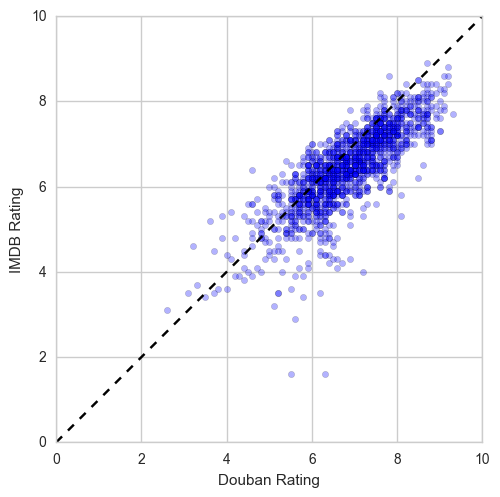

In [25]:
fig, ax = plt.subplots()
scatter_plot=ax.scatter(df.db_rating, df.imdb_rating, alpha=0.3)
x=[0,10]
plt.plot(x,x,'--',color='black')
plt.axis([0,10,0,10])
plt_configure(xlabel='Douban Rating', ylabel='IMDB Rating')
plt.gca().set_aspect('equal')

In [26]:
labels = df.name.tolist()
fig.set_size_inches(10,10)
plugins.connect(fig, plugins.PointHTMLTooltip(scatter_plot, labels))
mpld3.display(fig)
mpld3.save_html(fig,'test.html')

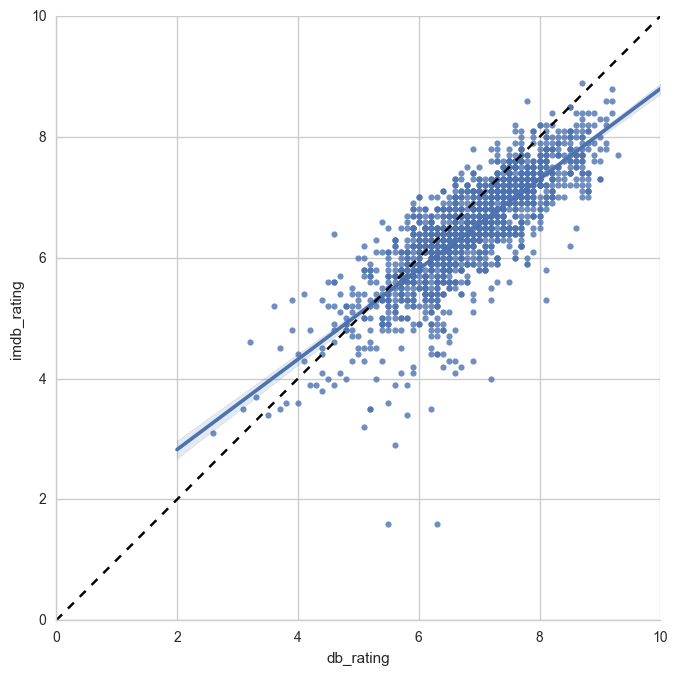

In [27]:
sns.pairplot(df, x_vars='db_rating', y_vars='imdb_rating', size=7, kind='reg')
x=[0,10]
plt.plot(x,x,'--',color='black')
plt.axis([0,10,0,10])
plt.gca().set_aspect('equal')

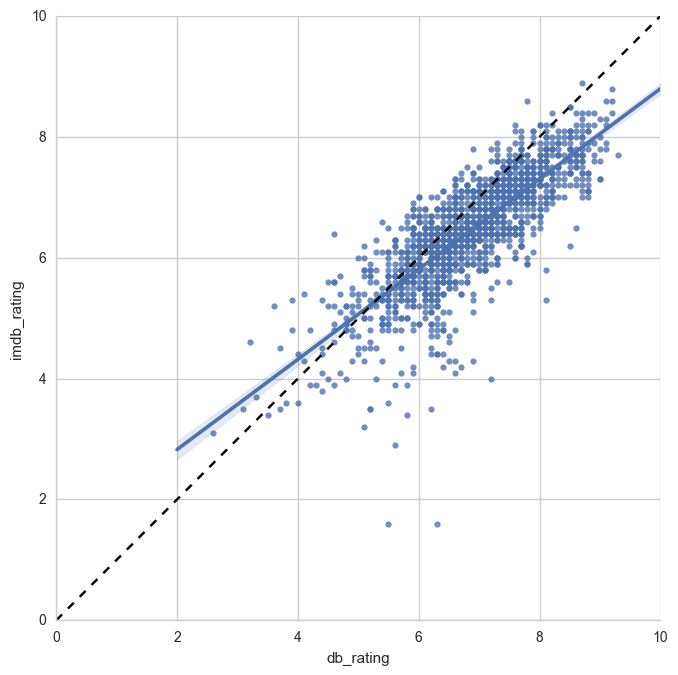

In [28]:
min_ratings_number = 1000
sns.pairplot(df, x_vars='db_rating', y_vars='imdb_rating', size=7, kind='reg')
x=[0,10]
plt.plot(x,x,'--',color='black')
plt.axis([0,10,0,10])
plt.gca().set_aspect('equal')

## 4.1 Outliars

In [29]:
min_ratings_number = 100
df = df.query("(db_rating>0) & \
               (db_ratings_count > @min_ratings_number) & \
               (imdb_ratings_count > @min_ratings_number)")

df['diff']=df['db_rating']-df['imdb_rating']
df['imdb_rank'] = df['imdb_rating'].rank()/len(df)*100
df['db_rank'] = df['db_rating'].rank()/len(df)*100
df['rank_diff']=df['db_rank']-df['imdb_rank']
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
count,1270.000000,1270.000000,1.270000e+03,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1.270000e+03
mean,6.457402,5.553465,6.859558e+04,6.836614,24483.784252,0.379213,50.039370,50.039370,-3.017009e-15
std,0.942335,1.713788,1.156387e+05,1.003480,51625.938068,0.615476,28.859986,28.864818,1.705263e+01
min,1.600000,0.900000,2.900000e+02,3.100000,102.000000,-1.800000,0.118110,0.078740,-5.000000e+01
25%,5.900000,4.300000,6.136000e+03,6.200000,1033.000000,0.000000,25.748031,25.984252,-9.931102e+00
50%,6.500000,5.600000,2.322250e+04,6.800000,4916.500000,0.400000,50.354331,49.212598,-8.267717e-01
75%,7.100000,6.800000,7.621850e+04,7.600000,21251.000000,0.700000,73.740157,76.653543,9.566929e+00
max,8.900000,10.000000,1.255291e+06,9.200000,586362.000000,4.700000,100.000000,99.921260,7.972441e+01


## 4.2 Movie Overviews

### 4.2.1 Bset Movies

In [30]:
df.sort_values(by='imdb_rating',ascending=False).head(10)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
1467,tt0110912,Tarantino XX: Pulp Fiction Event,8.9,9.4,1147612.0,8.7,240290,-0.2,100.000000,97.086614,-2.913386
211,tt1375666,Inception,8.8,7.4,1255291.0,9.2,586362,0.4,99.921260,99.921260,0.000000
1332,tt0082971,Raiders of the Lost Ark,8.6,9.0,574968.0,7.8,33528,-0.8,99.763780,83.228346,-16.535433
1184,tt1675434,The Intouchables,8.6,5.7,406147.0,9.1,257411,0.5,99.763780,99.645669,-0.118110
754,tt1424432,Senna,8.6,7.9,40906.0,9.2,3722,0.6,99.763780,99.921260,0.157480
1499,tt1853728,Django Unchained,8.5,8.1,789525.0,8.5,191003,0.0,99.566929,94.724409,-4.842520
1256,tt1345836,The Dark Knight Rises,8.5,7.8,975322.0,8.5,221766,0.0,99.566929,94.724409,-4.842520
967,tt1832382,A Separation,8.4,9.5,131912.0,8.7,96551,0.3,99.251969,97.086614,-2.165354
181,tt0435761,Toy Story 3,8.4,9.2,457959.0,8.8,154035,0.4,99.251969,98.307087,-0.944882
1372,tt0056172,Lawrence of Arabia,8.4,10.0,167930.0,8.6,16770,0.2,99.251969,95.905512,-3.346457


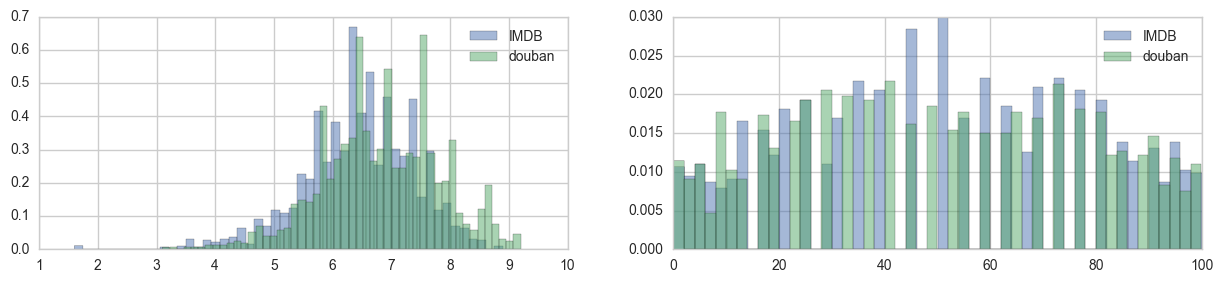

In [31]:
plt.subplot(1,2,1)
df['imdb_rating'].hist(bins=50, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=50,alpha=0.5, figsize=(15, 3), normed=True, label = 'douban')
plt.legend()

plt.subplot(1,2,2)
df['imdb_rank'].hist(bins=50, alpha=0.5, normed=True, label = 'IMDB')
df['db_rank'].hist(bins=50,alpha=0.5, figsize=(15, 3), normed=True, label = 'douban')
plt.legend()

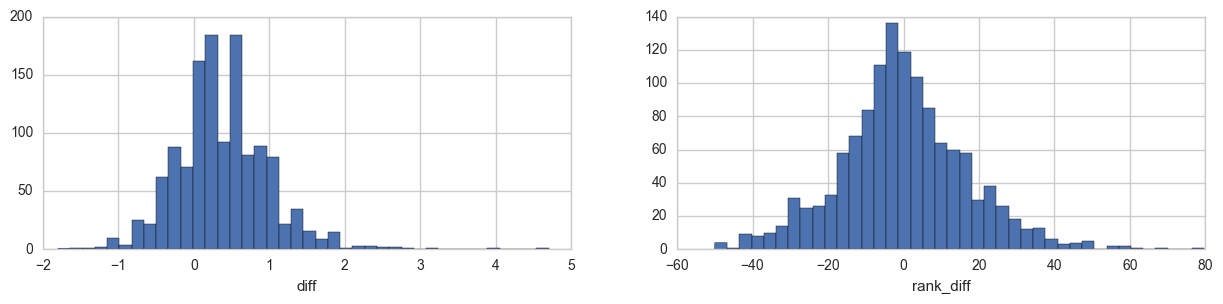

In [32]:
plt.subplot(1,2,1)
df['diff'].hist(bins=40,figsize=(15, 3))
plt.xlabel('diff')
plt.subplot(1,2,2)
df['rank_diff'].hist(bins=40)
plt.xlabel('rank_diff')

## 4.3. Absolute Difference

In [33]:
df.sort_values(by='diff',ascending=False).head(20)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
464,tt1702443,Justin Bieber: Never Say Never,1.6,5.2,73232.0,6.3,1959,4.7,0.118110,29.960630,29.842520
2061,tt3165608,Justin Bieber's Believe,1.6,3.9,16291.0,5.5,109,3.9,0.118110,8.188976,8.070866
1882,tt2515086,One Direction: This is Us,4.0,4.9,21372.0,7.2,448,3.2,1.535433,62.165354,60.629921
751,tt1922612,Glee: The 3D Concert Movie,5.3,4.8,4970.0,8.1,1522,2.8,10.472441,90.196850,79.724409
253,tt1666186,Vampires Suck,3.5,1.8,36693.0,6.2,17794,2.7,0.551181,25.984252,25.433071
84,tt1391137,Tyler Perry's Why Did I Get Married Too,4.3,4.3,7114.0,6.9,445,2.6,2.440945,52.598425,50.157480
162,tt1392197,Marmaduke,4.1,3.0,10414.0,6.6,3472,2.5,1.850394,41.968504,40.118110
157,tt1261945,Sex and the City 2,4.2,2.7,54189.0,6.7,34065,2.5,2.086614,45.748031,43.661417
905,tt0810913,Jack and Jill,3.4,2.3,53595.0,5.8,5886,2.4,0.354331,13.779528,13.425197
1246,tt2082232,China Heavyweight,5.8,7.7,291.0,8.1,1517,2.3,22.007874,90.196850,68.188976


## 4.4 Rank Difference

In [34]:
df.sort_values(by='rank_diff',ascending=False).head(30)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
751,tt1922612,Glee: The 3D Concert Movie,5.3,4.8,4970.0,8.1,1522,2.8,10.472441,90.196850,79.724409
1246,tt2082232,China Heavyweight,5.8,7.7,291.0,8.1,1517,2.3,22.007874,90.196850,68.188976
1882,tt2515086,One Direction: This is Us,4.0,4.9,21372.0,7.2,448,3.2,1.535433,62.165354,60.629921
369,tt1405500,For Colored Girls,5.9,5.0,5843.0,7.8,995,1.9,25.748031,83.228346,57.480315
1239,tt2215719,Katy Perry: Part of Me,5.9,5.7,11755.0,7.8,4304,1.9,25.748031,83.228346,57.480315
357,tt1477076,Saw 3D,5.6,2.4,60688.0,7.5,43276,1.9,16.220472,72.716535,56.496063
89,tt1462054,Letters to God,6.1,3.1,3720.0,7.9,1841,1.8,31.574803,85.708661,54.133858
84,tt1391137,Tyler Perry's Why Did I Get Married Too,4.3,4.3,7114.0,6.9,445,2.6,2.440945,52.598425,50.157480
244,tt0879870,Eat Pray Love,5.6,5.0,55894.0,7.3,66987,1.7,16.220472,65.433071,49.212598
727,tt0472181,The Smurfs,5.5,3.0,61010.0,7.2,76822,1.7,13.937008,62.165354,48.228346


# 5. Popular Moives Comparison (with min rating number)

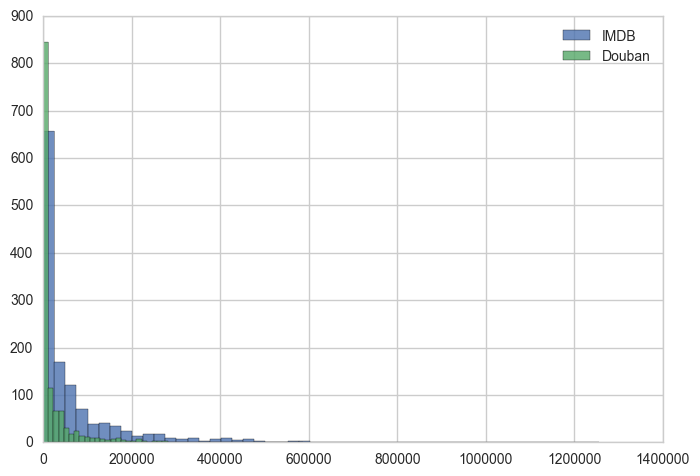

In [35]:
# Compare for stable rating?(more raters)
df['imdb_ratings_count'].hist(bins=50, alpha=0.8, label = 'IMDB')
df['db_ratings_count'].hist(bins=50,alpha=0.8, label = 'Douban')
plt.legend()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
count,954.000000,954.000000,9.540000e+02,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000
mean,6.581237,5.633124,8.965081e+04,6.960587,32358.733753,0.379350,53.725053,53.272834,-0.452219
std,0.894787,1.688748,1.265533e+05,0.934776,57417.648962,0.585522,28.139725,28.029256,16.868409
min,1.600000,0.900000,1.094000e+03,4.100000,1005.000000,-1.800000,0.118110,0.826772,-50.000000
25%,6.100000,4.500000,1.474125e+04,6.300000,3505.500000,0.000000,31.574803,29.960630,-10.000000
50%,6.600000,5.700000,4.443100e+04,6.900000,9564.500000,0.300000,55.039370,52.598425,-1.240157
75%,7.200000,6.800000,1.066442e+05,7.600000,36042.750000,0.700000,77.992126,76.653543,9.242126
max,8.900000,10.000000,1.255291e+06,9.200000,586362.000000,4.700000,100.000000,99.921260,79.724409


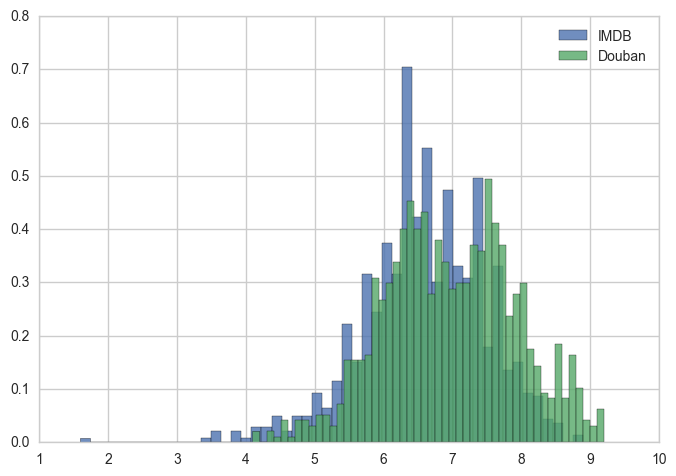

In [36]:
# Compare for stable rating?(more raters)
min_ratings_number = 1000
popular_movies = df.query("(db_ratings_count > @min_ratings_number) & \
                       (imdb_ratings_count > @min_ratings_number)")
popular_movies['imdb_rating'].hist(bins=50, alpha=0.8, normed=True, label = 'IMDB')
popular_movies['db_rating'].hist(bins=50,alpha=0.8, normed=True, label = 'Douban')
plt.legend()
popular_movies.describe()

In [37]:
popular_movies.sort_values(by='rank_diff',ascending=False).head(100)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
751,tt1922612,Glee: The 3D Concert Movie,5.3,4.8,4970.0,8.1,1522,2.8,10.472441,90.196850,79.724409
1239,tt2215719,Katy Perry: Part of Me,5.9,5.7,11755.0,7.8,4304,1.9,25.748031,83.228346,57.480315
357,tt1477076,Saw 3D,5.6,2.4,60688.0,7.5,43276,1.9,16.220472,72.716535,56.496063
89,tt1462054,Letters to God,6.1,3.1,3720.0,7.9,1841,1.8,31.574803,85.708661,54.133858
244,tt0879870,Eat Pray Love,5.6,5.0,55894.0,7.3,66987,1.7,16.220472,65.433071,49.212598
727,tt0472181,The Smurfs,5.5,3.0,61010.0,7.2,76822,1.7,13.937008,62.165354,48.228346
1394,tt1837587,War of Buttons,6.0,4.0,1377.0,7.6,1338,1.6,28.779528,76.653543,47.874016
155,tt1198101,Kites,6.0,6.2,8752.0,7.6,7163,1.6,28.779528,76.653543,47.874016
233,tt1193631,Step Up 3D,6.2,4.5,42605.0,7.7,20156,1.5,35.433071,80.236220,44.803150
157,tt1261945,Sex and the City 2,4.2,2.7,54189.0,6.7,34065,2.5,2.086614,45.748031,43.661417


In [38]:
popular_movies.query('(db_rating>7) | \
                    (imdb_rating>7)')
popular_movies.sort_values(by='rank_diff',ascending=False).head(100)

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
751,tt1922612,Glee: The 3D Concert Movie,5.3,4.8,4970.0,8.1,1522,2.8,10.472441,90.196850,79.724409
1239,tt2215719,Katy Perry: Part of Me,5.9,5.7,11755.0,7.8,4304,1.9,25.748031,83.228346,57.480315
357,tt1477076,Saw 3D,5.6,2.4,60688.0,7.5,43276,1.9,16.220472,72.716535,56.496063
89,tt1462054,Letters to God,6.1,3.1,3720.0,7.9,1841,1.8,31.574803,85.708661,54.133858
244,tt0879870,Eat Pray Love,5.6,5.0,55894.0,7.3,66987,1.7,16.220472,65.433071,49.212598
727,tt0472181,The Smurfs,5.5,3.0,61010.0,7.2,76822,1.7,13.937008,62.165354,48.228346
1394,tt1837587,War of Buttons,6.0,4.0,1377.0,7.6,1338,1.6,28.779528,76.653543,47.874016
155,tt1198101,Kites,6.0,6.2,8752.0,7.6,7163,1.6,28.779528,76.653543,47.874016
233,tt1193631,Step Up 3D,6.2,4.5,42605.0,7.7,20156,1.5,35.433071,80.236220,44.803150
157,tt1261945,Sex and the City 2,4.2,2.7,54189.0,6.7,34065,2.5,2.086614,45.748031,43.661417
